<a href="https://colab.research.google.com/github/m-tarro/ml2022-project/blob/main/ML_Project_(P14).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The whole process from start to finish

In [1]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import files
import pandas as pd
import io
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from itertools import permutations
from sklearn.metrics import accuracy_score

In [2]:
# Data transformation for clean input data to choose method

# Read input data
df_soidutee = pd.read_csv('https://raw.githubusercontent.com/m-tarro/ml2022-project/main/data/LI_soidutee.csv')
df_kiirused = pd.read_csv('https://raw.githubusercontent.com/m-tarro/ml2022-project/main/data/LINT_Tee_Piirkiirus.csv', sep =';')
df_kiirused = df_kiirused[['Tee_GID', 'Piirkiirus']]
df_unclean_data = pd.merge(df_soidutee, df_kiirused, how='left', left_on = 'GlobalID', right_on = 'Tee_GID')
del df_unclean_data['Tee_GID']

# Categorical data to numeric
df_train_cols = ['OBJECTID', 'Number' , 'Liik','Era_avalik', 'Soidutee_lai' ,'Suunalisus', 'Rada_arv', 'Piirkiirus', "GlobalID"]
df_train_numeric = df_unclean_data[df_train_cols]
for col in df_train_cols:
  if df_train_numeric[col].dtypes == 'category':
    df_train_numeric[col] = df_train_numeric[col].astype('Int8')
df_train_numeric['Suunalisus'] = df_train_numeric['Suunalisus'].astype('Int8')

# One-hot encoding
df_train_onehot = pd.get_dummies(df_train_numeric, columns = ['Era_avalik', 'Suunalisus'])
df_train_onehot['Omand_riik'] = df_train_onehot['Era_avalik_1'] + df_train_onehot['Era_avalik_2'] 
df_train_onehot['Ühesuunaline'] = df_train_onehot['Suunalisus_1']
df_train = df_train_onehot.drop([
    'Era_avalik_0','Era_avalik_1', 'Era_avalik_2', 'Era_avalik_3', 'Era_avalik_6', 
    'Suunalisus_0', 'Suunalisus_1',
    'OBJECTID', 'Number'], axis=1)

# Impute missing data
numerical_features = df_train.select_dtypes(include = ['int64','float64']).columns.values
numerical_impute = KNNImputer()
numerical_impute.fit(df_train[numerical_features])
df_train[numerical_features] = numerical_impute.transform(df_train[numerical_features])
df_train['Liik'] *= -1
df_train.head()

# Read test data
df_test = pd.read_csv('https://raw.githubusercontent.com/m-tarro/ml2022-project/main/data/test_labels.csv')

In [3]:
def model_fit(train, model, var_excl, pca_exp_var=0):
  model_col_header = type(model).__name__
  # Check for non-default parameters
  default_parameters = list(globals()[model_col_header]().__dict__.values())
  model_parameters = list(model.__dict__.values())
  different_parameters = list(set(model_parameters).difference(default_parameters))
  if 'Clustering' in model_col_header: # Simplification for column headers
    model_col_header = model_col_header.replace('Clustering', "")

  if 5 in different_parameters: # 5 clusters is default for our project
    different_parameters.remove(5)

  if len(different_parameters) > 0: # Different parameters as column header
    model_col_header = model_col_header + '_param(' + '.'.join(map(str,different_parameters)) + ')'

  # Training data specified
  train_data = train[['Liik', 'Omand_riik', 'Soidutee_lai', 'Ühesuunaline', 'Rada_arv', 'Piirkiirus']]
  train_data = train_data.loc[:, ~train_data.columns.isin(var_excl)]
  if pca_exp_var != 0: # PCA applied if required
    train_data = PCA(pca_exp_var,whiten=True).fit_transform(train_data)
    model_col_header = model_col_header + '_PCA' + str(int(pca_exp_var*100))

  if '' in var_excl:
    var_excl.remove('')

  if len(var_excl) > 0: # Check if some variables are to be excluded
    model_col_header = model_col_header + '_excl(' + '.'.join(map(str,var_excl)) + ')'

  # Included variables scaled and fitted onto model
  train_scaled = StandardScaler().fit_transform(train_data)
  train[model_col_header] = model.fit_predict(train_scaled)
  return train, model_col_header

def model_precision(train, test, model_col_header):
  # Check for possible permutations since the result the model gives is not ordered
  possible_permutations = list(permutations(range(5), 5))
  max_accuracy = 0
  max_accuracy_permutation = 0

  for j in range(len(possible_permutations)):
    train_permutation = train.replace({
      model_col_header : {
          possible_permutations[j][0]:0,
          possible_permutations[j][1]:1,
          possible_permutations[j][2]:2,
          possible_permutations[j][3]:3,
          possible_permutations[j][4]:4
          }
      })
    # Check for accuracy of current permutation
    train_test_merge = pd.merge(train_permutation, test, on=['GlobalID'], how='inner')
    acc_score_permutation = accuracy_score(test['label_test'], train_test_merge[model_col_header])
    
    if acc_score_permutation > max_accuracy:
      max_accuracy = acc_score_permutation
      max_accuracy_permutation = j
  # Best score of the permutations added to training data
  train = train.replace({
      model_col_header : {
          possible_permutations[max_accuracy_permutation][0]:0,
          possible_permutations[max_accuracy_permutation][1]:1,
          possible_permutations[max_accuracy_permutation][2]:2,
          possible_permutations[max_accuracy_permutation][3]:3,
          possible_permutations[max_accuracy_permutation][4]:4
          }
      })
  return round(max_accuracy,4), possible_permutations[max_accuracy_permutation], train[model_col_header]

In [4]:
# Testing out the models without parameters
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

variables_available = ['Liik', 'Omand_riik', 'Soidutee_lai', 'Ühesuunaline', 'Rada_arv', 'Piirkiirus']

models_to_test = list()
for var_to_exclude in ['','Liik', 'Omand_riik', 'Soidutee_lai', 'Ühesuunaline', 'Rada_arv', 'Piirkiirus']:
  for pca_exp_var in [0.99,0]:
    for Agg_aff in ['euclidean','manhattan']:
      #continue
      for Agg_link in ['ward','complete']:
        continue
        if Agg_link == 'ward' and Agg_aff == 'manhattan':
          continue
        models_to_test.append(tuple([AgglomerativeClustering(n_clusters=5, affinity=Agg_aff, linkage=Agg_link),[var_to_exclude],pca_exp_var]))
    models_to_test.append(tuple([KMeans(n_clusters=5, random_state = 0),[var_to_exclude],pca_exp_var]))
    for Gauss_cov_type in ['full', 'tied', 'diag', 'spherical']:
      continue
      models_to_test.append(tuple([GaussianMixture(n_components=5, covariance_type=Gauss_cov_type), [var_to_exclude],pca_exp_var]))

# Best model
# models_to_test.append(tuple([AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='complete'), ['Liik'],0.99]))

# To note - df_train adds new models as new columns whenever a new model is run
model_accuracies = dict()
for model in models_to_test:
  if len(model) == 3: # if PCA included
    current_model_fit = model_fit(df_train,model[0],model[1],model[2])
  else: # if PCA excluded
    current_model_fit = model_fit(df_train,model[0],model[1])
  current_model_results = model_precision(current_model_fit[0],df_test,current_model_fit[1])
  df_train[current_model_fit[1]] = current_model_results[2]
  print(f'Best accuracy: {"{0:.4f}".format(current_model_results[0])} with order {current_model_results[1]} for model {current_model_fit[1]}')
  model_accuracies.update({current_model_fit[1]: current_model_results[0]})
best_accuracies = sorted(model_accuracies.items(), reverse=True, key=lambda x: x[1])

print(f'\nBest accuracy of this set is {best_accuracies[0][1]}\
 for model {best_accuracies[0][0]}')

if len(models_to_test) > 1:
  print(f'This beat the 2nd model, acc {best_accuracies[1][1]} by \
  {"{0:.2f}".format(round((best_accuracies[0][1]/best_accuracies[1][1]-1)*100,2))}% \
  ({best_accuracies[1][0]})')
if len(models_to_test) > 2:
  print(f'      and the 3rd model, acc {best_accuracies[2][1]} by \
  {"{0:.2f}".format(round((best_accuracies[0][1]/best_accuracies[2][1]-1)*100,2))}% \
  ({best_accuracies[2][0]})')

Best accuracy: 0.6790 with order (0, 4, 3, 1, 2) for model KMeans_PCA99
Best accuracy: 0.6886 with order (3, 4, 2, 1, 0) for model KMeans
Best accuracy: 0.5602 with order (3, 0, 4, 2, 1) for model KMeans_PCA99_excl(Liik)
Best accuracy: 0.6469 with order (0, 1, 2, 4, 3) for model KMeans_excl(Liik)
Best accuracy: 0.6774 with order (4, 3, 2, 1, 0) for model KMeans_PCA99_excl(Omand_riik)
Best accuracy: 0.7496 with order (4, 1, 3, 2, 0) for model KMeans_excl(Omand_riik)
Best accuracy: 0.5875 with order (2, 4, 0, 1, 3) for model KMeans_PCA99_excl(Soidutee_lai)
Best accuracy: 0.6886 with order (3, 0, 2, 1, 4) for model KMeans_excl(Soidutee_lai)
Best accuracy: 0.6790 with order (3, 0, 1, 4, 2) for model KMeans_PCA99_excl(Ühesuunaline)
Best accuracy: 0.7640 with order (0, 4, 3, 1, 2) for model KMeans_excl(Ühesuunaline)
Best accuracy: 0.6758 with order (3, 4, 2, 1, 0) for model KMeans_PCA99_excl(Rada_arv)
Best accuracy: 0.6742 with order (3, 0, 1, 2, 4) for model KMeans_excl(Rada_arv)
Best accur

In [5]:
# Testing out models without removing columns

variables_available = ['Liik', 'Omand_riik', 'Soidutee_lai', 'Ühesuunaline', 'Rada_arv', 'Piirkiirus']

# Replace 'Liik' in list with variables you wish to exclude
# Replace 0.99 with the explained variance that is required from PCA (exclude if no PCA needed)

# For testing specific models
# Random examples shown
models_to_test = [
    (AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward'),[''],0.99),
    (AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='complete'),['Liik'],0.99),
    (KMeans(n_clusters=5, random_state = 0),[])
    ]

# For testing many models at once (to be commented out if single models tested)

models_to_test = list()
for var_to_exclude in ['']:
  for pca_exp_var in [0.99,0]:
    for Agg_aff in ['euclidean','manhattan']:
      #continue
      for Agg_link in ['ward','complete']:
        #continue
        if Agg_link == 'ward' and Agg_aff == 'manhattan':
          continue
        models_to_test.append(tuple([AgglomerativeClustering(n_clusters=5, affinity=Agg_aff, linkage=Agg_link),[var_to_exclude],pca_exp_var]))
    models_to_test.append(tuple([KMeans(n_clusters=5, random_state = 0),[var_to_exclude],pca_exp_var]))
    for Gauss_cov_type in ['full', 'tied', 'diag', 'spherical']:
      #continue
      models_to_test.append(tuple([GaussianMixture(n_components=5, covariance_type=Gauss_cov_type), [var_to_exclude],pca_exp_var]))

# To note - df_train adds new models as new columns whenever a new model is run
model_accuracies = dict()
for model in models_to_test:
  if len(model) == 3: # if PCA included
    current_model_fit = model_fit(df_train,model[0],model[1],model[2])
  else: # if PCA excluded
    current_model_fit = model_fit(df_train,model[0],model[1])
  current_model_results = model_precision(current_model_fit[0],df_test,current_model_fit[1])
  df_train[current_model_fit[1]] = current_model_results[2]
  print(f'Best accuracy: {"{0:.4f}".format(current_model_results[0])} with order {current_model_results[1]} for model {current_model_fit[1]}')
  model_accuracies.update({current_model_fit[1]: current_model_results[0]})
best_accuracies = sorted(model_accuracies.items(), reverse=True, key=lambda x: x[1])

print(f'\nBest accuracy of this set is {best_accuracies[0][1]}\
 for model {best_accuracies[0][0]}')

if len(models_to_test) > 1:
  print(f'This beat the 2nd model, acc {best_accuracies[1][1]} by \
  {"{0:.2f}".format(round((best_accuracies[0][1]/best_accuracies[1][1]-1)*100,2))}% \
  ({best_accuracies[1][0]})')
if len(models_to_test) > 2:
  print(f'      and the 3rd model, acc {best_accuracies[2][1]} by \
  {"{0:.2f}".format(round((best_accuracies[0][1]/best_accuracies[2][1]-1)*100,2))}% \
  ({best_accuracies[2][0]})')

Best accuracy: 0.6998 with order (1, 0, 4, 2, 3) for model Agglomerative_PCA99
Best accuracy: 0.8042 with order (4, 3, 1, 0, 2) for model Agglomerative_param(complete)_PCA99
Best accuracy: 0.6051 with order (1, 2, 4, 3, 0) for model Agglomerative_param(complete.manhattan)_PCA99
Best accuracy: 0.6790 with order (0, 4, 3, 1, 2) for model KMeans_PCA99
Best accuracy: 0.5795 with order (4, 0, 3, 1, 2) for model GaussianMixture_PCA99
Best accuracy: 0.6726 with order (3, 1, 4, 0, 2) for model GaussianMixture_param(tied)_PCA99
Best accuracy: 0.6886 with order (3, 1, 2, 4, 0) for model GaussianMixture_param(diag)_PCA99
Best accuracy: 0.6581 with order (4, 1, 2, 3, 0) for model GaussianMixture_param(spherical)_PCA99
Best accuracy: 0.6742 with order (3, 4, 2, 1, 0) for model Agglomerative
Best accuracy: 0.6726 with order (0, 4, 2, 1, 3) for model Agglomerative_param(complete)
Best accuracy: 0.6116 with order (0, 1, 4, 2, 3) for model Agglomerative_param(complete.manhattan)
Best accuracy: 0.6886 w

In [6]:
df_best_accuracies = pd.DataFrame(best_accuracies, columns=['Method','Accuracy'])
df_best_accuracies

,Method,Accuracy
0,Agglomerative_param(complete)_PCA99,0.8042
1,Agglomerative_PCA99,0.6998
2,GaussianMixture_param(spherical),0.6918
3,GaussianMixture_param(diag)_PCA99,0.6886
4,KMeans,0.6886
5,KMeans_PCA99,0.6790
6,GaussianMixture,0.6774
7,GaussianMixture_param(diag),0.6758
8,Agglomerative,0.6742
9,GaussianMixture_param(tied)_PCA99,0.6726


In [7]:
import matplotlib as plt
from sklearn import metrics

df_metrics_check = pd.merge(df_train, df_test, on=['GlobalID'], how='inner')

for i in df_best_accuracies['Method']:
  print(i)
  print(metrics.confusion_matrix(df_metrics_check['label_test'], df_metrics_check[i]))

Agglomerative_param(complete)_PCA99
[[ 89   9   0   1   3]
 [  3  26   2  41   0]
 [  0   6   0  35   0]
 [  0   0   0 310   0]
 [  0   0   0  22  76]]
Agglomerative_PCA99
[[ 92   7   0   0   3]
 [  1  67   4   0   0]
 [  0  31   2   8   0]
 [  0  23  88 199   0]
 [  0   0  16   6  76]]
GaussianMixture_param(spherical)
[[ 65   0   0   0  37]
 [ 39  25   0   7   1]
 [  5   5   0  28   3]
 [  8   1  38 263   0]
 [  0   0  13   7  78]]
GaussianMixture_param(diag)_PCA99
[[ 93   6   0   0   3]
 [  2  33  36   1   0]
 [  0   9  22  10   0]
 [  0   1 104 205   0]
 [  0   0  16   6  76]]
KMeans
[[ 65   0   0   0  37]
 [ 40  24   0   8   0]
 [  5   2   0  34   0]
 [  8   0  38 264   0]
 [  0   0  15   7  76]]
KMeans_PCA99
[[ 90   8   1   0   3]
 [  2  54  15   1   0]
 [  0  28   4   9   0]
 [  0   3 108 199   0]
 [  0   0  16   6  76]]
GaussianMixture
[[ 65   0  37   0   0]
 [ 17  46   1   8   0]
 [  2   5   0  34   0]
 [  8   3   0 261  38]
 [  0   0  41   7  50]]
GaussianMixture_param(diag)
[

In [8]:
for i in range(3,10,2):
  df_ensemble = df_train[list(pd.DataFrame(best_accuracies, columns=['Method','Accuracy'])[:i]['Method'])]
  colname = 'Ensemble_top'+str(i)
  df_ensemble['Ensemble_top'] = df_ensemble.mode(axis=1)[0].astype(int)
  df_train[colname] = df_ensemble['Ensemble_top']
  df_ensemble['GlobalID'] = df_train['GlobalID']
  df_ensemble = pd.merge(df_ensemble, df_test, on=['GlobalID'], how='inner')
  print(i, np.sum(df_ensemble['label_test'] == df_ensemble['Ensemble_top'])/len(df_ensemble))

3 0.7736757624398074
5 0.7752808988764045
7 0.7993579454253612
9 0.7447833065810594


In [9]:
df_train.head()

,Liik,Soidutee_lai,Rada_arv,Piirkiirus,GlobalID,Omand_riik,Ühesuunaline,KMeans_PCA99,KMeans,KMeans_PCA99_excl(Liik),...,Agglomerative_param(complete),Agglomerative_param(complete.manhattan),GaussianMixture,GaussianMixture_param(tied),GaussianMixture_param(diag),GaussianMixture_param(spherical),Ensemble_top3,Ensemble_top5,Ensemble_top7,Ensemble_top9
0,-3.0,7.0,1.0,90.0,{99E17C40-A54F-4C36-8783-FE581FB4D4C4},1,0,0,4,0,...,0,3,2,0,1,4,0,0,0,0
1,-3.0,7.0,1.0,90.0,{43D451EA-A03D-4ACB-9E76-C6A7D5B93397},1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,-3.0,7.0,1.6,70.0,{11479604-F792-4DC2-AC32-8E54B9C1A9A1},1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,-1.0,10.0,1.8,80.0,{300AC1B7-503E-4C3D-846C-FD32AED5F308},1,0,0,4,2,...,0,3,2,0,1,4,0,0,0,0
4,-3.0,7.0,1.4,74.0,{487F7419-D20F-486D-97C7-C78F7BC46B49},1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [11]:
df_train.to_csv('ensemble_results.csv') 
files.download('ensemble_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Slaidile:

Ensemble

Parim tulemus vs kõige loogilisem tulemus

Heatmap

Mudelite skeem


# Progress and Project History




In [ ]:
from google.colab import files
import pandas as pd
import io

df = pd.read_csv('https://raw.githubusercontent.com/m-tarro/ml2022-project/main/data/LI_soidutee.csv')

       OBJECTID  Number  Liik  Tyyp               Nimi  Era_avalik  Kate  \
0         27899  2230.0     3   1.0          Kulbilohu           1  13.0   
1         27900  2230.0     3   1.0          Kulbilohu           1  13.0   
2         27901  2230.0     3   1.0          Kulbilohu           1  13.0   
3         27902     3.0     1   1.0  Jõhvi-Tartu-Valga           1  13.0   
4         27903  2230.0     3   1.0          Kulbilohu           1  13.0   
...         ...     ...   ...   ...                ...         ...   ...   
13478     71233     NaN    12   1.0           Ujula tn           2  19.0   
13479     71234     NaN    12   1.0           Ujula tn           2  19.0   
13480     71235     NaN    12   1.0           Ujula tn           2  19.0   
13481     71236     NaN    12   1.0           Ujula tn           2  19.0   
13482     71237     NaN    12   1.0           Ujula tn           2  19.0   

       Soidutee_lai  Suunalisus  Rada_arv  Shape__Length  \
0               7.0        

In [ ]:
kiirused = pd.read_csv('https://raw.githubusercontent.com/m-tarro/ml2022-project/main/data/LINT_Tee_Piirkiirus.csv', sep =';')

          ID      Nimi     Number                  Liik  \
0          1       NaN        NaN              jalgrada   
1          2       NaN        NaN  kvartalisisene tänav   
2          3       NaN  7950356.0           kõrvaltänav   
3          4       NaN        NaN               jalgtee   
4          5       NaN        NaN              jalgrada   
...      ...       ...        ...                   ...   
16588  16589  Ümera tn  7950422.0           kõrvaltänav   
16589  16590  Ümera tn  7950422.0           kõrvaltänav   
16590  16591  Ümera tn  7950422.0           kõrvaltänav   
16591  16592  Ümera tn  7950422.0           kõrvaltänav   
16592  16593  Ümera tn  7950422.0           kõrvaltänav   

                                      Tee_GID  Piirkiirus  \
0      {1A9D7C8D-BC8D-42C6-A5BD-82F1CA18A92F}          50   
1      {33C74406-F93C-4213-9331-80A66F8A267F}          20   
2      {D3C59FEA-47D9-42EE-AD2E-4586384C79ED}          50   
3      {042D6D61-33F8-4CE8-B1BF-CB39639C8F13}  

In [ ]:
kiirused = kiirused[['Tee_GID', 'Piirkiirus']]

Merging the data frames.

In [ ]:
df_cd = pd.merge(df, kiirused, how='left', left_on = 'GlobalID', right_on = 'Tee_GID')
del df_cd['Tee_GID']

In [ ]:
df_cd.sort_values('Nimi').groupby(['Nimi'])[['Nimi','Piirkiirus']].describe()

Piirkiirus                                    \
                                      count       mean        std   min   25%   
Nimi                                                                            
                                     4338.0  47.935685  17.094989   5.0  50.0   
<Null>                                  0.0        NaN        NaN   NaN   NaN   
A. Elleri tn                            1.0  30.000000        NaN  30.0  30.0   
A. H. Tammsaare tn                      9.0  30.000000  15.000000  20.0  20.0   
A. Haava tn                            10.0  50.000000   0.000000  50.0  50.0   
...                                     ...        ...        ...   ...   ...   
Ülenurme tn                             6.0  30.000000   0.000000  30.0  30.0   
Ülenurme tn J 5, 6, 6a, 7, 7a, 8        1.0  30.000000        NaN  30.0  30.0   
Ülenurme-Külitse                       66.0  70.000000  19.215378  50.0  50.0   
Ülikooli tn                             9.0  23.333333  10.000000  20.0  20.0   
Ümera tn                                5.0  50.000000   0.000000  50.0  50.0   

                                                    
                                   50%   75%   max  
Nimi                                                
                                  50.0  50.0  90.0  
<Null>                             NaN   NaN   NaN  
A. Elleri tn                      30.0  30.0  30.0  
A. H. Tammsaare tn                20.0  50.0  50.0  
A. Haava tn                       50.0  50.0  50.0  
...                                ...   ...   ...  
Ülenurme tn                       30.0  30.0  30.0  
Ülenurme tn J 5, 6, 6a, 7, 7a, 8  30.0  30.0  30.0  
Ülenurme-Külitse                  70.0  90.0  90.0  
Ülikooli tn                       20.0  20.0  50.0  
Ümera tn                          50.0  50.0  50.0  

[1300 rows x 8 columns]

## Choice of relevant categories

In [ ]:
df_cd.isnull().sum()

OBJECTID            0
Number           5281
Liik                0
Tyyp                1
Nimi               35
Era_avalik          0
Kate               15
Soidutee_lai       32
Suunalisus         23
Rada_arv         5535
Shape__Length       0
GlobalID            0
Piirkiirus       2573
dtype: int64

In [ ]:
# Martti: I think that the Type variable should be ignored since most of its' values are missing or unspecified
# Tyyp 1 = Missing type
df_cd["Tyyp"].value_counts()

1.0    11984
7.0      735
5.0      414
3.0      314
2.0       33
4.0        2
Name: Tyyp, dtype: int64

In [ ]:
# Martti: Information about cover material also has lots of missing or unspecified values
df_cd["Kate"].value_counts()

13.0    6600
10.0    4106
32.0    1527
15.0     384
41.0     276
27.0     227
0.0       90
26.0      80
28.0      60
29.0      51
19.0      29
22.0      13
23.0      12
18.0      11
16.0       2
Name: Kate, dtype: int64

In [ ]:
sagedused_liik = pd.DataFrame(pd.value_counts(df_cd['Liik']))
sagedused_tyyp = pd.DataFrame(pd.value_counts(df_cd['Tyyp']))
sagedused_kate = pd.DataFrame(pd.value_counts(df_cd['Kate']))

In [ ]:
# Martti: Väheke lihtsustan graafikute kuvamist, ehk dokumentatsiooni XLSX SharePointist alla laadida ja siia üles laadida
# uploaded_dokumentatsioon = files.upload()
# dok_xlsx = pd.read_excel(io.BytesIO(uploaded_dokumentatsioon['LINT_andmemudeli_dokumentatsioon_v2.xlsx']), 
#                         sheet_name = ["Tee_liik", "Tee_kate", "Tee_tyyp"])
dok_xlsx = pd.read_excel('https://github.com/m-tarro/ml2022-project/blob/main/data/LINT_andmemudeli_dokumentatsioon_v2.xlsx?raw=true', 
                         sheet_name = ["Tee_liik", "Tee_kate", "Tee_tyyp"])
dok_liik = pd.DataFrame(dok_xlsx["Tee_liik"], columns=['Domeeni väärtus', 'Domeeni kirjeldus/nimetus'])
dok_liik = dok_liik.rename(columns={"Domeeni väärtus":"Domeen", "Domeeni kirjeldus/nimetus":"Kirjeldus"}).set_index("Domeen")
dok_tyyp = pd.DataFrame(dok_xlsx["Tee_tyyp"], columns=['Domeeni väärtus', 'Domeeni kirjeldus/nimetus'])
dok_tyyp = dok_tyyp.rename(columns={"Domeeni väärtus":"Domeen", "Domeeni kirjeldus/nimetus":"Kirjeldus"}).set_index("Domeen")
dok_kate = pd.DataFrame(dok_xlsx["Tee_kate"], columns=['Domeeni väärtus', 'Domeeni kirjeldus/nimetus'])
dok_kate = dok_kate.rename(columns={"Domeeni väärtus":"Domeen", "Domeeni kirjeldus/nimetus":"Kirjeldus"}).set_index("Domeen")

In [ ]:
sagedused_liik = sagedused_liik.join(dok_liik)
sagedused_tyyp = sagedused_tyyp.join(dok_tyyp)
sagedused_kate = sagedused_kate.join(dok_kate)
sagedused_liik

,Liik,Kirjeldus
12,5609,kvartalisisene tänav
10,3436,kõrvaltänav
9,1213,jaotustänav
7,872,muu tee
3,797,kõrvalmaantee
1,570,põhimaantee
8,469,põhitänav
2,356,tugimaantee
11,120,veotänav
4,41,ramp või ühendustee


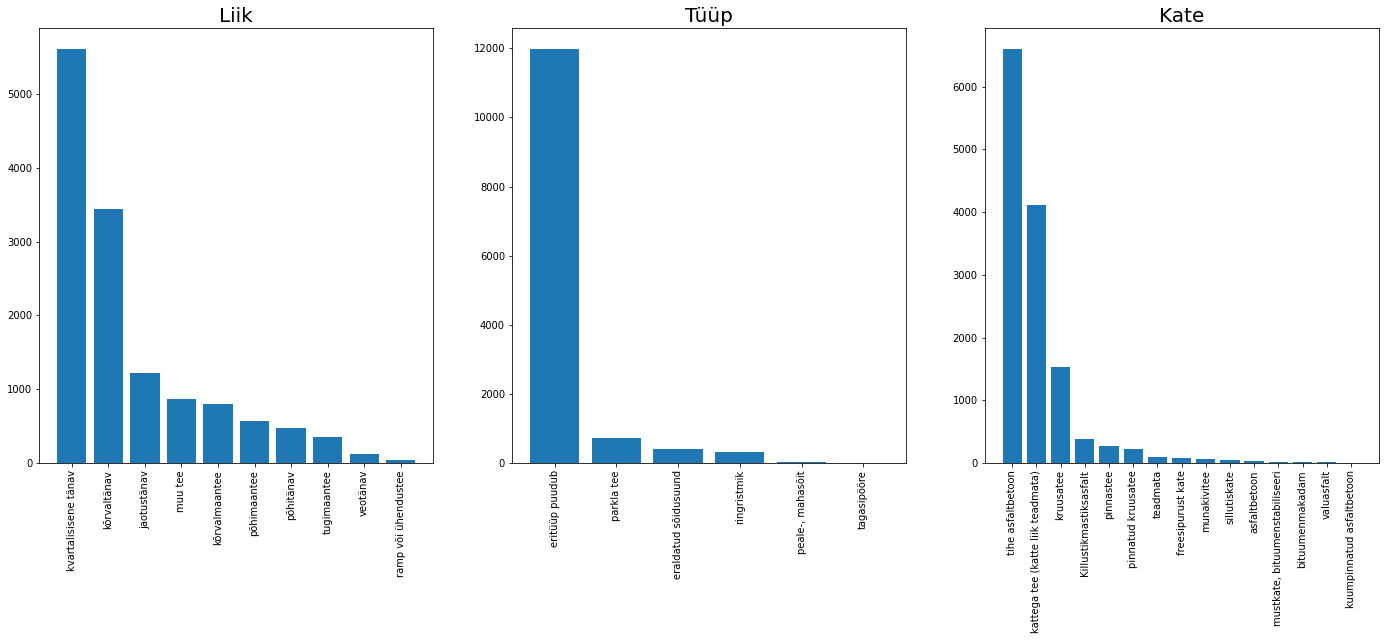

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(24, 8))

axs[0].bar(sagedused_liik["Kirjeldus"],sagedused_liik["Liik"])
axs[0].tick_params(axis='x', labelrotation=90)
axs[0].set_title("Liik", fontsize = 20)

axs[1].bar(sagedused_tyyp["Kirjeldus"],sagedused_tyyp["Tyyp"])
axs[1].tick_params(axis='x', labelrotation=90)
axs[1].set_title("Tüüp", fontsize = 20)

axs[2].bar(sagedused_kate["Kirjeldus"],sagedused_kate["Kate"])
axs[2].tick_params(axis='x', labelrotation=90)
axs[2].set_title("Kate", fontsize = 20)
plt.show()

## Methods for clustering

### K-prototypes (not used in the final version)

#### Setup

In [ ]:
cols = ['Liik','Tyyp','Era_avalik', 'Kate', 'Suunalisus'] #Siia veel midagi lisada? #Täpsustus: siin on siis kategoorilised tunnused

for col in cols:
    df_cd[col] = df_cd[col].astype('category')

df_cd.dtypes

OBJECTID            int64
Number            float64
Liik             category
Tyyp             category
Nimi               object
Era_avalik       category
Kate             category
Soidutee_lai      float64
Suunalisus       category
Rada_arv          float64
Shape__Length     float64
GlobalID           object
Piirkiirus        float64
dtype: object

Information about K-prototypes could be found here: https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb

This method is meant for mixed-type data.

In [ ]:
!pip install -q kmodes
import kmodes

In [ ]:
df_test = df_cd[['Liik','Tyyp','Era_avalik', 'Kate', 'Soidutee_lai' ,'Suunalisus', 'Rada_arv', 'Piirkiirus']]

catColumnsPos = [df_test.columns.get_loc(col) for col in list(df_test.select_dtypes('category').columns)]
print('Categorical columns           : {}'.format(list(df_test.select_dtypes('category').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Liik', 'Tyyp', 'Era_avalik', 'Kate', 'Suunalisus']
Categorical columns position  : [0, 1, 2, 3, 5]


In [ ]:
import numpy as np
from kmodes.kprototypes import KPrototypes

kprototype = KPrototypes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 0)
try:
  kprototype.fit_predict(df_test, categorical = catColumnsPos)
except ValueError:
  print('K-prototypes does not except NA-s')

K-prototypes algoritm ei aktsepteeri puuduvaid väärtusi


#### Imputing categorical traits (SimpleImputer)

Ignoring rows with NAs is not an option since we want to classify all the streets in the dataset. Thus we need to impute.

In [ ]:
df_test.isnull().sum()/len(df_test) #Share of missing values

Liik            0.000000
Tyyp            0.000074
Era_avalik      0.000000
Kate            0.001113
Soidutee_lai    0.002373
Suunalisus      0.001706
Rada_arv        0.410517
Piirkiirus      0.190833
dtype: float64

SimpleImputer uses the most frequent value within the column for the missing values. Since categorical traits do not have many missing values, this should not really affect the end results.

In [ ]:
numerical_features = df_test.select_dtypes(include = ['int64','float64']).columns.values
categorical_features = df_test.select_dtypes(exclude = ['int64','float64']).columns.values

In [ ]:
from sklearn.impute import SimpleImputer
cat_impute = SimpleImputer(strategy='most_frequent')
cat_impute.fit(df_test[categorical_features])

SimpleImputer(strategy='most_frequent')

In [ ]:
df_test[categorical_features] = cat_impute.transform(df_test[categorical_features])

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


#### Imputing numerical traits (KNN)

In [ ]:
from sklearn.impute import KNNImputer
num_impute = KNNImputer()
num_impute.fit(df_test[numerical_features])

KNNImputer()

In [ ]:
df_test[numerical_features] = num_impute.transform(df_test[numerical_features]) #Pidevate tunnuste imputeerimine

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
df_test.isnull().sum()/len(df_test)

Liik            0.0
Tyyp            0.0
Era_avalik      0.0
Kate            0.0
Soidutee_lai    0.0
Suunalisus      0.0
Rada_arv        0.0
Piirkiirus      0.0
dtype: float64

#### Fitting

K-prototypes once again

In [ ]:
import numpy as np
from kmodes.kprototypes import KPrototypes

kprototype = KPrototypes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 0)
kprototype.fit_predict(df_test, categorical = catColumnsPos)

array([1, 1, 0, ..., 0, 0, 4], dtype=uint16)

In [ ]:
df_cd['Cluster_Labels'] = kprototype.labels_

In [ ]:
#df_cd.to_csv('k_prototypes.csv') 
#files.download('k_prototypes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### How to order the labels?

In [ ]:
df_cd.head()

,OBJECTID,Number,Liik,Tyyp,Nimi,Era_avalik,Kate,Soidutee_lai,Suunalisus,Rada_arv,Shape__Length,GlobalID,Piirkiirus,Cluster_Labels
0,27899,2230.0,3,1.0,Kulbilohu,1,13.0,7.0,0.0,NaN,107.253584,{99E17C40-A54F-4C36-8783-FE581FB4D4C4},90.0,1
1,27900,2230.0,3,1.0,Kulbilohu,1,13.0,7.0,1.0,1.0,58.348444,{43D451EA-A03D-4ACB-9E76-C6A7D5B93397},90.0,1
2,27901,2230.0,3,1.0,Kulbilohu,1,13.0,7.0,1.0,NaN,158.679191,{11479604-F792-4DC2-AC32-8E54B9C1A9A1},70.0,0
3,27902,3.0,1,1.0,Jõhvi-Tartu-Valga,1,13.0,10.0,0.0,NaN,42.223216,{300AC1B7-503E-4C3D-846C-FD32AED5F308},80.0,1
4,27903,2230.0,3,1.0,Kulbilohu,1,13.0,7.0,1.0,NaN,168.706048,{487F7419-D20F-486D-97C7-C78F7BC46B49},NaN,0


In [ ]:
df_cd.groupby(['Cluster_Labels'])[['Soidutee_lai' , 'Rada_arv', 'Piirkiirus']].mean()

,Soidutee_lai,Rada_arv,Piirkiirus
Cluster_Labels,,,
0,7.243736,1.843750,69.556452
1,5.722100,1.888620,89.662237
2,6.118037,1.996063,40.000000
3,5.453433,1.951691,27.165605
4,6.411861,2.112853,50.000000


In [ ]:
df_cd.groupby(['Cluster_Labels'])[['Soidutee_lai' , 'Rada_arv','Piirkiirus']].std()

,Soidutee_lai,Rada_arv,Piirkiirus
Cluster_Labels,,,
0,1.929855,0.652472,2.062986
1,2.932434,0.541654,1.807029
2,1.748360,0.506188,0.000000
3,1.333665,0.224618,4.768219
4,2.754354,0.734741,0.000000


In [ ]:
pd.set_option('display.max_columns', None)
df_cd.groupby(['Cluster_Labels'])[['Soidutee_lai' , 'Rada_arv', 'Piirkiirus']].describe().round(3).T

Cluster_Labels            0         1        2         3         4
Soidutee_lai count  439.000  1905.000  815.000  3539.000  6753.000
             mean     7.244     5.722    6.118     5.453     6.412
             std      1.930     2.932    1.748     1.334     2.754
             min      2.700     0.000    1.000     0.000     0.000
             25%      7.000     3.300    5.000     4.900     5.000
             50%      7.000     7.000    5.900     5.100     5.000
             75%      7.000     7.000    7.200     6.200     7.000
             max     10.000    13.800   17.200    16.200    31.000
Rada_arv     count  192.000   413.000  762.000  2691.000  3890.000
             mean     1.844     1.889    1.996     1.952     2.113
             std      0.652     0.542    0.506     0.225     0.735
             min      1.000     1.000    1.000     1.000     1.000
             25%      1.000     2.000    2.000     2.000     2.000
             50%      2.000     2.000    2.000     2.000     2.000
             75%      2.000     2.000    2.000     2.000     2.000
             max      4.000     6.000    6.000     3.000     8.000
Piirkiirus   count  248.000  1806.000   34.000  3297.000  5525.000
             mean    69.556    89.662   40.000    27.166    50.000
             std      2.063     1.807    0.000     4.768     0.000
             min     60.000    80.000   40.000     5.000    50.000
             25%     70.000    90.000   40.000    20.000    50.000
             50%     70.000    90.000   40.000    30.000    50.000
             75%     70.000    90.000   40.000    30.000    50.000
             max     70.000    90.000   40.000    30.000    50.000

### K-prototypes (w/o tyyp, kate)

In [ ]:
df_test_lihtsustatud = df_test[['Liik','Era_avalik', 'Soidutee_lai' ,'Suunalisus', 'Rada_arv', 'Piirkiirus']]
catColumnsPos_lihtsustatud = [df_test_lihtsustatud.columns.get_loc(col) for col in ['Liik', 'Era_avalik', 'Suunalisus']]

In [ ]:
kprototype_lihtsustatud = KPrototypes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 0)
kprototype_lihtsustatud.fit_predict(df_test_lihtsustatud, categorical = catColumnsPos_lihtsustatud)

array([1, 1, 2, ..., 2, 2, 4], dtype=uint16)

In [ ]:
df_cd['Cluster_Labels_lihtsustatud'] = kprototype_lihtsustatud.labels_

In [ ]:
df_cd.groupby(['Cluster_Labels','Cluster_Labels_lihtsustatud'])[['Soidutee_lai' , 'Rada_arv', 'Piirkiirus']].describe().round(3).T

Cluster_Labels                     0         1        2                  3  \
Cluster_Labels_lihtsustatud        2         1        0        4         0   
Soidutee_lai count           439.000  1905.000  481.000  334.000  2643.000   
             mean              7.244     5.722    6.148    6.075     5.441   
             std               1.930     2.932    1.694    1.825     1.365   
             min               2.700     0.000    1.000    2.000     1.500   
             25%               7.000     3.300    5.400    5.000     4.850   
             50%               7.000     7.000    6.000    5.000     5.100   
             75%               7.000     7.000    7.500    7.100     6.100   
             max              10.000    13.800   11.000   17.200    16.200   
Rada_arv     count           192.000   413.000  429.000  333.000  2119.000   
             mean              1.844     1.889    1.914    2.102     1.958   
             std               0.652     0.542    0.361    0.632     0.214   
             min               1.000     1.000    1.000    1.000     1.000   
             25%               1.000     2.000    2.000    2.000     2.000   
             50%               2.000     2.000    2.000    2.000     2.000   
             75%               2.000     2.000    2.000    2.000     2.000   
             max               4.000     6.000    4.000    6.000     3.000   
Piirkiirus   count           248.000  1806.000   34.000    0.000  2402.000   
             mean             69.556    89.662   40.000      NaN    30.000   
             std               2.063     1.807    0.000      NaN     0.000   
             min              60.000    80.000   40.000      NaN    30.000   
             25%              70.000    90.000   40.000      NaN    30.000   
             50%              70.000    90.000   40.000      NaN    30.000   
             75%              70.000    90.000   40.000      NaN    30.000   
             max              70.000    90.000   40.000      NaN    30.000   

Cluster_Labels                               4  
Cluster_Labels_lihtsustatud        3         4  
Soidutee_lai count           896.000  6753.000  
             mean              5.490     6.412  
             std               1.236     2.754  
             min               0.000     0.000  
             25%               5.000     5.000  
             50%               5.050     5.000  
             75%               6.200     7.000  
             max              16.000    31.000  
Rada_arv     count           572.000  3890.000  
             mean              1.928     2.113  
             std               0.258     0.735  
             min               1.000     1.000  
             25%               2.000     2.000  
             50%               2.000     2.000  
             75%               2.000     2.000  
             max               2.000     8.000  
Piirkiirus   count           895.000  5525.000  
             mean             19.559    50.000  
             std               2.075     0.000  
             min               5.000    50.000  
             25%              20.000    50.000  
             50%              20.000    50.000  
             75%              20.000    50.000  
             max              20.000    50.000

In [ ]:
df_cd.head()

,OBJECTID,Number,Liik,Tyyp,Nimi,Era_avalik,Kate,Soidutee_lai,Suunalisus,Rada_arv,Shape__Length,GlobalID,Piirkiirus,Cluster_Labels,Cluster_Labels_lihtsustatud,Cluster_Labels_lihtsustatud3
0,27899,2230.0,3,1.0,Kulbilohu,1,13.0,7.0,0.0,NaN,107.253584,{99E17C40-A54F-4C36-8783-FE581FB4D4C4},90.0,1,1,1
1,27900,2230.0,3,1.0,Kulbilohu,1,13.0,7.0,1.0,1.0,58.348444,{43D451EA-A03D-4ACB-9E76-C6A7D5B93397},90.0,1,1,1
2,27901,2230.0,3,1.0,Kulbilohu,1,13.0,7.0,1.0,NaN,158.679191,{11479604-F792-4DC2-AC32-8E54B9C1A9A1},70.0,0,2,1
3,27902,3.0,1,1.0,Jõhvi-Tartu-Valga,1,13.0,10.0,0.0,NaN,42.223216,{300AC1B7-503E-4C3D-846C-FD32AED5F308},80.0,1,1,1
4,27903,2230.0,3,1.0,Kulbilohu,1,13.0,7.0,1.0,NaN,168.706048,{487F7419-D20F-486D-97C7-C78F7BC46B49},NaN,0,2,0


In [ ]:
#df_cd.to_csv('test_uus_lihtsustatud.csv') 
#files.download('test_uus_lihtsustatud.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Presentation feedback, next steps

Presentation feedback:

Try clustering on a smaller area of data to evaluate the model

There are methods for hierarchical clustering that we should try on smaller data sets as well.

Next steps:

Scale numerical data

Use methods intended for numerical data



**Thoughts and ideas from preliminary presentations:**

Since we found out that type and cover are not really informative, then rest of the categorical traits could be translated into numeric form logically. Entirely numerical dataset would give us much more possibilities. 

## Numerical data

In [ ]:
cols = ['OBJECTID', 'Number' , 'Liik','Era_avalik', 'Soidutee_lai' ,'Suunalisus', 'Rada_arv', 'Piirkiirus', "GlobalID"]

df_numeric = df_cd[cols]
df_numeric.dtypes

OBJECTID           int64
Number           float64
Liik            category
Era_avalik      category
Soidutee_lai     float64
Suunalisus      category
Rada_arv         float64
Piirkiirus       float64
GlobalID          object
dtype: object

In [ ]:
for col in cols:
  if df_numeric[col].dtypes == 'category':
    df_numeric[col] = df_numeric[col].astype('Int8')

df_numeric['Suunalisus'] = df_numeric['Suunalisus'].astype('Int8')

<ipython-input-45-119f77947fb4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[col] = df_numeric[col].astype('Int8')
<ipython-input-45-119f77947fb4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['Suunalisus'] = df_numeric['Suunalisus'].astype('Int8')


In [ ]:
df_numeric.head()

,OBJECTID,Number,Liik,Era_avalik,Soidutee_lai,Suunalisus,Rada_arv,Piirkiirus,GlobalID
0,27899,2230.0,3,1,7.0,0,NaN,90.0,{99E17C40-A54F-4C36-8783-FE581FB4D4C4}
1,27900,2230.0,3,1,7.0,1,1.0,90.0,{43D451EA-A03D-4ACB-9E76-C6A7D5B93397}
2,27901,2230.0,3,1,7.0,1,NaN,70.0,{11479604-F792-4DC2-AC32-8E54B9C1A9A1}
3,27902,3.0,1,1,10.0,0,NaN,80.0,{300AC1B7-503E-4C3D-846C-FD32AED5F308}
4,27903,2230.0,3,1,7.0,1,NaN,NaN,{487F7419-D20F-486D-97C7-C78F7BC46B49}


In [ ]:
df_one_hot = pd.get_dummies(df_numeric, columns = ['Era_avalik', 'Suunalisus'])
df_one_hot.head()

,OBJECTID,Number,Liik,Soidutee_lai,Rada_arv,Piirkiirus,GlobalID,Era_avalik_0,Era_avalik_1,Era_avalik_2,Era_avalik_3,Era_avalik_6,Suunalisus_0,Suunalisus_1
0,27899,2230.0,3,7.0,NaN,90.0,{99E17C40-A54F-4C36-8783-FE581FB4D4C4},0,1,0,0,0,1,0
1,27900,2230.0,3,7.0,1.0,90.0,{43D451EA-A03D-4ACB-9E76-C6A7D5B93397},0,1,0,0,0,0,1
2,27901,2230.0,3,7.0,NaN,70.0,{11479604-F792-4DC2-AC32-8E54B9C1A9A1},0,1,0,0,0,0,1
3,27902,3.0,1,10.0,NaN,80.0,{300AC1B7-503E-4C3D-846C-FD32AED5F308},0,1,0,0,0,1,0
4,27903,2230.0,3,7.0,NaN,NaN,{487F7419-D20F-486D-97C7-C78F7BC46B49},0,1,0,0,0,0,1


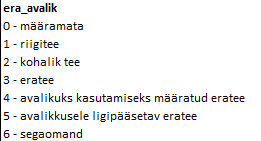

One variable for ownership should be enough - is the road governmental or not.

Direction of the road could also be described with one variable - two-directional or not.

In [ ]:
df_one_hot['Omand_riik'] = df_one_hot['Era_avalik_1'] + df_one_hot['Era_avalik_2'] 


df_one_hot['Kahesuunaline'] = df_one_hot['Suunalisus_0']

df_one_hot = df_one_hot.drop(['Era_avalik_0','Era_avalik_1', 'Era_avalik_2', 'Era_avalik_3', 'Era_avalik_6', 'Suunalisus_0', 'Suunalisus_1'], axis=1)
df_one_hot.head()

,OBJECTID,Number,Liik,Soidutee_lai,Rada_arv,Piirkiirus,GlobalID,Omand_riik,Kahesuunaline
0,27899,2230.0,3,7.0,NaN,90.0,{99E17C40-A54F-4C36-8783-FE581FB4D4C4},1,1
1,27900,2230.0,3,7.0,1.0,90.0,{43D451EA-A03D-4ACB-9E76-C6A7D5B93397},1,0
2,27901,2230.0,3,7.0,NaN,70.0,{11479604-F792-4DC2-AC32-8E54B9C1A9A1},1,0
3,27902,3.0,1,10.0,NaN,80.0,{300AC1B7-503E-4C3D-846C-FD32AED5F308},1,1
4,27903,2230.0,3,7.0,NaN,NaN,{487F7419-D20F-486D-97C7-C78F7BC46B49},1,0


In [ ]:
df_one_hot.describe()

,OBJECTID,Number,Liik,Soidutee_lai,Rada_arv,Piirkiirus,Omand_riik,Kahesuunaline
count,13483.000000,8.202000e+03,13483.000000,13451.000000,7948.000000,10910.000000,13483.000000,13483.000000
mean,38836.419640,6.264907e+06,9.463621,6.071355,2.028938,50.078368,0.704443,0.887859
std,7144.344106,3.274895e+06,3.212045,2.453748,0.581946,20.845098,0.456310,0.315552
min,27899.000000,2.000000e+00,1.000000,0.000000,1.000000,5.000000,0.000000,0.000000
25%,32643.000000,7.950031e+06,9.000000,5.000000,2.000000,30.000000,0.000000,1.000000
50%,38291.000000,7.950267e+06,10.000000,5.100000,2.000000,50.000000,1.000000,1.000000
75%,44892.500000,7.950513e+06,12.000000,7.000000,2.000000,50.000000,1.000000,1.000000
max,71237.000000,9.490163e+06,12.000000,31.000000,8.000000,90.000000,1.000000,1.000000


In [ ]:
from sklearn.impute import KNNImputer

numerical_features = df_one_hot.select_dtypes(include = ['int64','float64']).columns.values

num_impute = KNNImputer()
num_impute.fit(df_one_hot[numerical_features])

df_one_hot[numerical_features] = num_impute.transform(df_one_hot[numerical_features])


In [ ]:
df_one_hot.isnull().sum()/len(df_one_hot)

OBJECTID         0.0
Number           0.0
Liik             0.0
Soidutee_lai     0.0
Rada_arv         0.0
Piirkiirus       0.0
GlobalID         0.0
Omand_riik       0.0
Kahesuunaline    0.0
dtype: float64

In [ ]:
#df_one_hot.to_csv('test_numeric.csv') 
#files.download('test_numeric.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## PCA

In [ ]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt


# plt.figure(figsize=(10, 7))
# plt.title("Without PCA")

# selected_data = df_one_hot[variables]
# clusters = shc.linkage(selected_data, 
#             method='ward', 
#             metric="euclidean")
# shc.dendrogram(Z=clusters)
# plt.show()

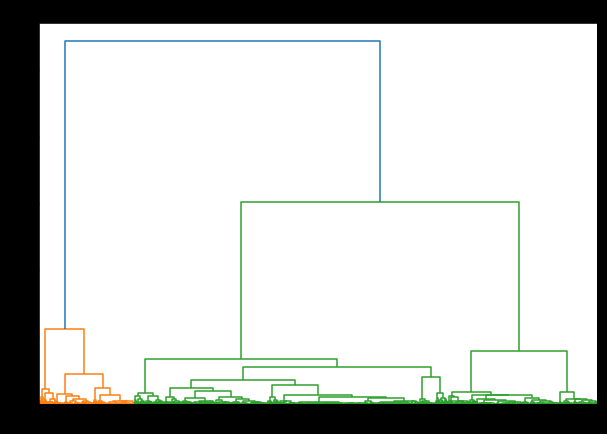

In [ ]:
df_one_hot[variables].head()

,Liik,Omand_riik,Soidutee_lai,Kahesuunaline,Rada_arv,Piirkiirus
0,3,1,7.0,1,1.8,90.0
1,3,1,7.0,0,1.0,90.0
2,3,1,7.0,0,1.8,70.0
3,1,1,10.0,1,2.0,80.0
4,3,1,7.0,0,1.8,74.0


Multiplying the road category with -1 so that higher priority roads would have higher values

In [ ]:
df_pca_testing = df_one_hot[variables]
df_pca_testing['Liik'] *= -1
df_pca_testing

<ipython-input-58-0ef108f14d89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca_testing['Liik'] *= -1


,Liik,Omand_riik,Soidutee_lai,Kahesuunaline,Rada_arv,Piirkiirus
0,-3,1,7.0,1,1.8,90.0
1,-3,1,7.0,0,1.0,90.0
2,-3,1,7.0,0,1.8,70.0
3,-1,1,10.0,1,2.0,80.0
4,-3,1,7.0,0,1.8,74.0
...,...,...,...,...,...,...
13478,-12,1,5.0,0,2.0,46.0
13479,-12,1,7.0,0,2.0,46.0
13480,-12,1,7.0,0,2.0,46.0
13481,-12,1,7.0,0,2.0,46.0


In [ ]:
df_pca_testing.describe().round(3)

,Liik,Omand_riik,Soidutee_lai,Kahesuunaline,Rada_arv,Piirkiirus
count,13483.000,13483.000,13483.000,13483.000,13483.000,13483.000
mean,-9.464,0.704,6.070,0.888,2.010,49.617
std,3.212,0.456,2.452,0.316,0.468,19.427
min,-12.000,0.000,0.000,0.000,1.000,5.000
25%,-12.000,0.000,5.000,1.000,2.000,30.000
50%,-10.000,1.000,5.100,1.000,2.000,50.000
75%,-9.000,1.000,7.000,1.000,2.000,50.000
max,-1.000,1.000,31.000,1.000,8.000,90.000


In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardizing the features
scale = StandardScaler().fit_transform(df_pca_testing)
print(scale)

[[ 2.01238192  0.64773607  0.37937149  0.35539448 -0.4482046   2.07874032]
 [ 2.01238192  0.64773607  0.37937149 -2.8137747  -2.15651346  2.07874032]
 [ 2.01238192  0.64773607  0.37937149 -2.8137747  -0.4482046   1.04923155]
 ...
 [-0.78967558  0.64773607  0.37937149 -2.8137747  -0.02112738 -0.18617898]
 [-0.78967558  0.64773607  0.37937149 -2.8137747  -0.02112738 -0.18617898]
 [-0.78967558  0.64773607 -0.43626066 -2.8137747  -0.02112738 -0.18617898]]


In [ ]:
from sklearn.cluster import AgglomerativeClustering

variables = ['Liik', 'Omand_riik', 'Soidutee_lai' ,'Kahesuunaline', 'Rada_arv', 'Piirkiirus']

hierarchical_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
labels_noPCA = hierarchical_cluster.fit_predict(df_one_hot[variables])

In [ ]:
from sklearn.decomposition import PCA

pca95 = PCA(0.95,whiten=True).fit(df_pca_testing)
df_one_hot_pca95 = pca95.transform(df_pca_testing)
pca99 = PCA(0.99,whiten=True).fit(df_pca_testing)
df_one_hot_pca99 = pca99.transform(df_pca_testing)
df_one_hot_pca95.shape,df_one_hot_pca99.shape

((13483, 1), (13483, 3))

In [ ]:
df_one_hot_pca_df = df_one_hot

hierarchical_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
df_one_hot_pca_df['Cluster_Labels_hierarchical_PCA_95'] = hierarchical_cluster.fit_predict(df_one_hot_pca95)
df_one_hot_pca_df['Cluster_Labels_hierarchical_PCA_99'] = hierarchical_cluster.fit_predict(df_one_hot_pca99)
df_one_hot_pca_df['Cluster_Labels_hierachical_noPCA'] = labels_noPCA

In [ ]:
df_one_hot_pca_df.head()

,OBJECTID,Number,Liik,Soidutee_lai,Rada_arv,Piirkiirus,GlobalID,Omand_riik,Kahesuunaline,Cluster_Labels_hierachical_noPCA,Cluster_Labels_hierarchical_PCA_95,Cluster_Labels_hierarchical_PCA_99
0,27899.0,2230.0,-3,7.0,1.8,90.0,{99E17C40-A54F-4C36-8783-FE581FB4D4C4},1,1,1,4,0
1,27900.0,2230.0,-3,7.0,1.0,90.0,{43D451EA-A03D-4ACB-9E76-C6A7D5B93397},1,0,1,4,0
2,27901.0,2230.0,-3,7.0,1.8,70.0,{11479604-F792-4DC2-AC32-8E54B9C1A9A1},1,0,3,3,0
3,27902.0,3.0,-1,10.0,2.0,80.0,{300AC1B7-503E-4C3D-846C-FD32AED5F308},1,1,1,4,0
4,27903.0,2230.0,-3,7.0,1.8,74.0,{487F7419-D20F-486D-97C7-C78F7BC46B49},1,0,3,3,0


In [ ]:
#df_one_hot_pca_df.to_csv('test_numeric_pca.csv') 
#files.download('test_numeric_pca.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## K-means

In [ ]:
from sklearn.cluster import KMeans

kmeans_noPCA = KMeans(n_clusters=5, random_state = 0).fit_predict(df_one_hot[variables])
kmeans_PCA95 = KMeans(n_clusters=5, random_state = 0).fit_predict(df_one_hot_pca95)
kmeans_PCA99 = KMeans(n_clusters=5, random_state = 0).fit_predict(df_one_hot_pca99)

In [ ]:
df_w_labels = df_one_hot_pca_df.copy()

df_w_labels['Cluster_Labels_kmeans_noPCA'] = kmeans_noPCA
df_w_labels['Cluster_Labels_kmeans_PCA95'] = kmeans_PCA95
df_w_labels['Cluster_Labels_kmeans_PCA99'] = kmeans_PCA99

In [ ]:
df_w_labels.head()

,OBJECTID,Number,Liik,Soidutee_lai,Rada_arv,Piirkiirus,GlobalID,Omand_riik,Kahesuunaline,Cluster_Labels_hierachical_noPCA,Cluster_Labels_hierarchical_PCA_95,Cluster_Labels_hierarchical_PCA_99,Cluster_Labels_kmeans_noPCA,Cluster_Labels_kmeans_PCA95,Cluster_Labels_kmeans_PCA99
0,27899.0,2230.0,-3,7.0,1.8,90.0,{99E17C40-A54F-4C36-8783-FE581FB4D4C4},1,1,1,4,0,1,1,2
1,27900.0,2230.0,-3,7.0,1.0,90.0,{43D451EA-A03D-4ACB-9E76-C6A7D5B93397},1,0,1,4,0,1,1,2
2,27901.0,2230.0,-3,7.0,1.8,70.0,{11479604-F792-4DC2-AC32-8E54B9C1A9A1},1,0,3,3,0,3,3,2
3,27902.0,3.0,-1,10.0,2.0,80.0,{300AC1B7-503E-4C3D-846C-FD32AED5F308},1,1,1,4,0,1,1,2
4,27903.0,2230.0,-3,7.0,1.8,74.0,{487F7419-D20F-486D-97C7-C78F7BC46B49},1,0,3,3,0,3,3,2


## Prioritising

Models spit out labels that are not in the order of priority which makes comparing the models impossible without any additional corrections.

Test data is ~5% of the length of the intial training data and has category lables based following classification scheme:

0 - Main highway

1 - Main urban street

2 - Important urban connecting road

3 - Smaller urban roads

4 - Other rural roads

Here manual reordering is tried but this fails miserably. A way neater approach and solution is shown in the final result script.

In [ ]:
pd.set_option('display.max_columns', None)
df_w_labels.groupby(['Cluster_Labels_hierachical_noPCA'])[['Soidutee_lai' , 'Rada_arv', 'Piirkiirus', 'Omand_riik', 'Kahesuunaline']].describe().round(3).T

Cluster_Labels_hierachical_noPCA         0         1         2        3  \
Soidutee_lai  count               7579.000  1891.000  2693.000  417.000   
              mean                   6.336     5.748     5.542    7.362   
              std                    2.640     2.856     1.663    1.898   
              min                    0.000     0.000     0.000    0.000   
              25%                    5.000     3.300     4.900    7.000   
              50%                    5.000     7.000     5.100    7.000   
              75%                    7.000     7.000     6.400    8.600   
              max                   27.000    13.800    31.000   15.600   
Rada_arv      count               7579.000  1891.000  2693.000  417.000   
              mean                   2.052     1.939     1.974    1.922   
              std                    0.562     0.274     0.293    0.490   
              min                    1.000     1.000     1.000    1.000   
              25%                    2.000     2.000     2.000    2.000   
              50%                    2.000     2.000     2.000    2.000   
              75%                    2.000     2.000     2.000    2.000   
              max                    8.000     4.000     8.000    5.000   
Piirkiirus    count               7579.000  1891.000  2693.000  417.000   
              mean                  49.117    89.519    30.228   68.134   
              std                    3.252     2.053     1.255    3.898   
              min                   36.000    78.000    24.000   58.000   
              25%                   50.000    90.000    30.000   66.000   
              50%                   50.000    90.000    30.000   70.000   
              75%                   50.000    90.000    30.000   70.000   
              max                   62.000    90.000    40.000   78.000   
Omand_riik    count               7579.000  1891.000  2693.000  417.000   
              mean                   0.663     0.740     0.779    0.928   
              std                    0.473     0.439     0.415    0.259   
              min                    0.000     0.000     0.000    0.000   
              25%                    0.000     0.000     1.000    1.000   
              50%                    1.000     1.000     1.000    1.000   
              75%                    1.000     1.000     1.000    1.000   
              max                    1.000     1.000     1.000    1.000   
Kahesuunaline count               7579.000  1891.000  2693.000  417.000   
              mean                   0.878     0.878     0.931    0.753   
              std                    0.328     0.328     0.254    0.432   
              min                    0.000     0.000     0.000    0.000   
              25%                    1.000     1.000     1.000    1.000   
              50%                    1.000     1.000     1.000    1.000   
              75%                    1.000     1.000     1.000    1.000   
              max                    1.000     1.000     1.000    1.000   

Cluster_Labels_hierachical_noPCA        4  
Soidutee_lai  count               903.000  
              mean                  5.485  
              std                   1.250  
              min                   0.000  
              25%                   5.000  
              50%                   5.000  
              75%                   6.200  
              max                  16.000  
Rada_arv      count               903.000  
              mean                  1.956  
              std                   0.250  
              min                   1.000  
              25%                   2.000  
              50%                   2.000  
              75%                   2.000  
              max                   3.600  
Piirkiirus    count               903.000  
              mean                 19.527  
              std                   2.143  
              min                   5.000  


For 'Cluster_Labels_hierachical_noPCA' -> 1,0,2,4,3

In [ ]:
df_w_labels.groupby(['Cluster_Labels_hierarchical_PCA_95'])[['Soidutee_lai' , 'Rada_arv', 'Piirkiirus', 'Omand_riik', 'Kahesuunaline']].describe().round(3).T

Cluster_Labels_hierarchical_PCA_95         0         1         2        3  \
Soidutee_lai  count                 3461.000  1286.000  6497.000  346.000   
              mean                     5.495     6.696     6.273    7.436   
              std                      1.495     3.174     2.513    1.849   
              min                      0.000     0.000     0.000    0.000   
              25%                      5.000     5.000     5.000    7.000   
              50%                      5.000     5.800     5.000    7.000   
              75%                      6.300     7.500     7.000    8.875   
              max                     31.000    26.900    27.000   15.600   
Rada_arv      count                 3461.000  1286.000  6497.000  346.000   
              mean                     1.969     2.077     2.045    1.901   
              std                      0.268     0.694     0.533    0.445   
              min                      1.000     1.000     1.000    1.000   
              25%                      2.000     2.000     2.000    2.000   
              50%                      2.000     2.000     2.000    2.000   
              75%                      2.000     2.000     2.000    2.000   
              max                      8.000     7.000     8.000    3.000   
Piirkiirus    count                 3461.000  1286.000  6497.000  346.000   
              mean                    27.253    41.809    50.391   69.566   
              std                      4.746     3.769     1.734    1.976   
              min                      5.000    34.000    48.000   66.000   
              25%                     20.000    38.000    50.000   70.000   
              50%                     30.000    42.000    50.000   70.000   
              75%                     30.000    46.000    50.000   70.000   
              max                     32.000    46.000    64.000   76.000   
Omand_riik    count                 3461.000  1286.000  6497.000  346.000   
              mean                     0.747     0.730     0.654    0.945   
              std                      0.435     0.444     0.476    0.228   
              min                      0.000     0.000     0.000    0.000   
              25%                      0.000     0.000     0.000    1.000   
              50%                      1.000     1.000     1.000    1.000   
              75%                      1.000     1.000     1.000    1.000   
              max                      1.000     1.000     1.000    1.000   
Kahesuunaline count                 3461.000  1286.000  6497.000  346.000   
              mean                     0.936     0.844     0.882    0.746   
              std                      0.246     0.363     0.323    0.436   
              min                      0.000     0.000     0.000    0.000   
              25%                      1.000     1.000     1.000    0.000   
              50%                      1.000     1.000     1.000    1.000   
              75%                      1.000     1.000     1.000    1.000   
              max                      1.000     1.000     1.000    1.000   

Cluster_Labels_hierarchical_PCA_95         4  
Soidutee_lai  count                 1893.000  
              mean                     5.749  
              std                      2.855  
              min                      0.000  
              25%                      3.300  
              50%                      7.000  
              75%                      7.000  
              max                     13.800  
Rada_arv      count                 1893.000  
              mean                     1.939  
              std                      0.275  
              min                      1.000  
              25%                      2.000  
              50%                      2.000  
              75%                      2.000  
              max                      4.000  
Piirkiirus    count                 1893.00

For 'Cluster_Labels_hierachical_PCA_95' -> 4,1,2,0,3

In [ ]:
df_w_labels.groupby(['Cluster_Labels_hierarchical_PCA_99'])[['Soidutee_lai' , 'Rada_arv', 'Piirkiirus', 'Omand_riik', 'Kahesuunaline']].describe().round(3).T

Cluster_Labels_hierarchical_PCA_99         0         1         2        3  \
Soidutee_lai  count                 1763.000  6850.000  3595.000  374.000   
              mean                     7.708     5.877     5.378   15.125   
              std                      1.429     1.691     1.412    2.942   
              min                      0.000     1.000     0.000   10.600   
              25%                      7.000     5.000     4.900   13.700   
              50%                      7.000     5.000     5.000   14.200   
              75%                     10.000     7.000     6.200   16.400   
              max                     10.700    12.000    10.600   31.000   
Rada_arv      count                 1763.000  6850.000  3595.000  374.000   
              mean                     1.915     1.982     1.961    3.516   
              std                      0.381     0.382     0.237    1.236   
              min                      1.000     1.000     1.000    1.000   
              25%                      2.000     2.000     2.000    2.000   
              50%                      2.000     2.000     2.000    4.000   
              75%                      2.000     2.000     2.000    4.000   
              max                      5.000     6.000     5.000    8.000   
Piirkiirus    count                 1763.000  6850.000  3595.000  374.000   
              mean                    74.492    49.260    28.090   48.578   
              std                     18.159     4.504     5.967    6.228   
              min                     26.000    20.000     5.000   20.000   
              25%                     50.000    50.000    24.000   46.500   
              50%                     88.000    50.000    30.000   50.000   
              75%                     90.000    50.000    30.000   50.000   
              max                     90.000    82.000    70.000   90.000   
Omand_riik    count                 1763.000  6850.000  3595.000  374.000   
              mean                     1.000     0.622     0.748    0.997   
              std                      0.000     0.485     0.434    0.052   
              min                      1.000     0.000     0.000    0.000   
              25%                      1.000     0.000     0.000    1.000   
              50%                      1.000     1.000     1.000    1.000   
              75%                      1.000     1.000     1.000    1.000   
              max                      1.000     1.000     1.000    1.000   
Kahesuunaline count                 1763.000  6850.000  3595.000  374.000   
              mean                     0.736     0.894     0.932    0.869   
              std                      0.441     0.307     0.253    0.338   
              min                      0.000     0.000     0.000    0.000   
              25%                      0.000     1.000     1.000    1.000   
              50%                      1.000     1.000     1.000    1.000   
              75%                      1.000     1.000     1.000    1.000   
              max                      1.000     1.000     1.000    1.000   

Cluster_Labels_hierarchical_PCA_99        4  
Soidutee_lai  count                 901.000  
              mean                    3.328  
              std                     1.931  
              min                     0.000  
              25%                     3.000  
              50%                     3.100  
              75%                     5.000  
              max                     7.600  
Rada_arv      count                 901.000  
              mean                    1.972  
              std                     0.236  
              min                     1.000  
              25%                     2.000  
              50%                     2.000  
              75%                     2.000  
              max                     3.200  
Piirkiirus    count                 901.000  
              

For 'Cluster_Labels_hierachical_PCA_99' -> 4,3,0,1,2

In [ ]:
df_w_labels.groupby(['Cluster_Labels_kmeans_noPCA'])[['Soidutee_lai' , 'Rada_arv', 'Piirkiirus', 'Omand_riik', 'Kahesuunaline']].describe().round(3).T

Cluster_Labels_kmeans_noPCA         0         1         2        3        4
Soidutee_lai  count          3028.000  1885.000  7238.000  425.000  907.000
              mean              5.638     5.736     6.327    7.476    5.489
              std               1.787     2.851     2.640    2.075    1.256
              min               0.000     0.000     0.000    0.000    0.000
              25%               4.900     3.300     5.000    7.000    5.000
              50%               5.100     7.000     5.000    7.000    5.000
              75%               6.600     7.000     7.000    8.900    6.200
              max              31.000    13.800    27.000   21.000   16.000
Rada_arv      count          3028.000  1885.000  7238.000  425.000  907.000
              mean              1.983     1.939     2.051    1.933    1.956
              std               0.330     0.274     0.562    0.518    0.249
              min               1.000     1.000     1.000    1.000    1.000
              25%               2.000     2.000     2.000    2.000    2.000
              50%               2.000     2.000     2.000    2.000    2.000
              75%               2.000     2.000     2.000    2.000    2.000
              max               8.000     4.000     8.000    5.000    3.600
Piirkiirus    count          3028.000  1885.000  7238.000  425.000  907.000
              mean             31.169    89.555    49.608   68.240   19.548
              std               2.891     1.950     2.353    4.064    2.161
              min              26.000    80.000    40.000   58.000    5.000
              25%              30.000    90.000    50.000   66.000   20.000
              50%              30.000    90.000    50.000   70.000   20.000
              75%              30.000    90.000    50.000   70.000   20.000
              max              40.000    90.000    60.000   78.000   25.000
Omand_riik    count          3028.000  1885.000  7238.000  425.000  907.000
              mean              0.773     0.740     0.660    0.934    0.650
              std               0.419     0.439     0.474    0.248    0.477
              min               0.000     0.000     0.000    0.000    0.000
              25%               1.000     0.000     0.000    1.000    0.000
              50%               1.000     1.000     1.000    1.000    1.000
              75%               1.000     1.000     1.000    1.000    1.000
              max               1.000     1.000     1.000    1.000    1.000
Kahesuunaline count          3028.000  1885.000  7238.000  425.000  907.000
              mean              0.926     0.877     0.877    0.755    0.929
              std               0.261     0.328     0.328    0.430    0.256
              min               0.000     0.000     0.000    0.000    0.000
              25%               1.000     1.000     1.000    1.000    1.000
              50%               1.000     1.000     1.000    1.000    1.000
              75%               1.000     1.000     1.000    1.000    1.000
              max               1.000     1.000     1.000    1.000    1.000

For 'Cluster_Labels_kmeans_noPCA' -> 1,0,2,4,3

In [ ]:
df_w_labels.groupby(['Cluster_Labels_kmeans_PCA95'])[['Soidutee_lai' , 'Rada_arv', 'Piirkiirus', 'Omand_riik', 'Kahesuunaline']].describe().round(3).T

Cluster_Labels_kmeans_PCA95         0         1         2        3        4
Soidutee_lai  count          7252.000  1885.000  3028.000  411.000  907.000
              mean              6.330     5.736     5.641    7.451    5.489
              std               2.635     2.851     1.797    2.116    1.256
              min               0.000     0.000     0.000    0.000    0.000
              25%               5.000     3.300     4.900    7.000    5.000
              50%               5.000     7.000     5.100    7.000    5.000
              75%               7.000     7.000     6.600    9.000    6.200
              max              27.000    13.800    31.000   21.000   16.000
Rada_arv      count          7252.000  1885.000  3028.000  411.000  907.000
              mean              2.050     1.939     1.984    1.944    1.956
              std               0.561     0.274     0.334    0.518    0.249
              min               1.000     1.000     1.000    1.000    1.000
              25%               2.000     2.000     2.000    2.000    2.000
              50%               2.000     2.000     2.000    2.000    2.000
              75%               2.000     2.000     2.000    2.000    2.000
              max               8.000     4.000     8.000    5.000    3.600
Piirkiirus    count          7252.000  1885.000  3028.000  411.000  907.000
              mean             49.623    89.555    31.169   68.603   19.548
              std               2.376     1.950     2.891    3.619    2.161
              min              40.000    80.000    26.000   60.000    5.000
              25%              50.000    90.000    30.000   66.000   20.000
              50%              50.000    90.000    30.000   70.000   20.000
              75%              50.000    90.000    30.000   70.000   20.000
              max              58.000    90.000    40.000   78.000   25.000
Omand_riik    count          7252.000  1885.000  3028.000  411.000  907.000
              mean              0.661     0.740     0.773    0.927    0.650
              std               0.473     0.439     0.419    0.260    0.477
              min               0.000     0.000     0.000    0.000    0.000
              25%               0.000     0.000     1.000    1.000    0.000
              50%               1.000     1.000     1.000    1.000    1.000
              75%               1.000     1.000     1.000    1.000    1.000
              max               1.000     1.000     1.000    1.000    1.000
Kahesuunaline count          7252.000  1885.000  3028.000  411.000  907.000
              mean              0.876     0.877     0.926    0.764    0.929
              std               0.329     0.328     0.261    0.425    0.256
              min               0.000     0.000     0.000    0.000    0.000
              25%               1.000     1.000     1.000    1.000    1.000
              50%               1.000     1.000     1.000    1.000    1.000
              75%               1.000     1.000     1.000    1.000    1.000
              max               1.000     1.000     1.000    1.000    1.000

For 'Cluster_Labels_kmeans_PCA95' -> 1,0,2,4,3

In [ ]:
df_w_labels.groupby(['Cluster_Labels_kmeans_PCA99'])[['Soidutee_lai' , 'Rada_arv', 'Piirkiirus', 'Omand_riik', 'Kahesuunaline']].describe().round(3).T

Cluster_Labels_kmeans_PCA99        0         1         2         3        4
Soidutee_lai  count          918.000  6096.000  1764.000  3974.000  731.000
              mean             3.326     5.621     7.704     5.446   12.699
              std              1.929     1.404     1.440     1.383    3.282
              min              0.000     0.000     0.000     0.000    9.100
              25%              3.000     5.000     7.000     4.900   10.000
              50%              3.100     5.000     7.000     5.100   11.300
              75%              5.000     6.600    10.000     6.400   14.200
              max              7.600     9.300    10.700    10.000   31.000
Rada_arv      count          918.000  6096.000  1764.000  3974.000  731.000
              mean             1.971     1.974     1.915     1.945    2.940
              std              0.236     0.322     0.382     0.285    1.182
              min              1.000     1.000     1.000     1.000    1.000
              25%              2.000     2.000     2.000     2.000    2.000
              50%              2.000     2.000     2.000     2.000    3.000
              75%              2.000     2.000     2.000     2.000    4.000
              max              3.200     6.000     5.000     5.000    8.000
Piirkiirus    count          918.000  6096.000  1764.000  3974.000  731.000
              mean            89.584    49.748    74.475    29.415   48.170
              std              3.013     3.616    18.168     7.211    6.618
              min             54.000    30.000    26.000     5.000   20.000
              25%             90.000    50.000    50.000    30.000   47.000
              50%             90.000    50.000    88.000    30.000   50.000
              75%             90.000    50.000    90.000    30.000   50.000
              max             90.000    82.000    90.000    58.000   90.000
Omand_riik    count          918.000  6096.000  1764.000  3974.000  731.000
              mean             0.460     0.579     1.000     0.767    0.999
              std              0.499     0.494     0.000     0.422    0.037
              min              0.000     0.000     1.000     0.000    0.000
              25%              0.000     0.000     1.000     1.000    1.000
              50%              0.000     1.000     1.000     1.000    1.000
              75%              1.000     1.000     1.000     1.000    1.000
              max              1.000     1.000     1.000     1.000    1.000
Kahesuunaline count          918.000  6096.000  1764.000  3974.000  731.000
              mean             0.968     0.917     0.735     0.908    0.803
              std              0.175     0.276     0.441     0.290    0.398
              min              0.000     0.000     0.000     0.000    0.000
              25%              1.000     1.000     0.000     1.000    1.000
              50%              1.000     1.000     1.000     1.000    1.000
              75%              1.000     1.000     1.000     1.000    1.000
              max              1.000     1.000     1.000     1.000    1.000

For 'Cluster_Labels_kmeans_PCA99' -> 2,3,4,1,0

In [ ]:
df_w_labels_pr = df_w_labels.copy()

df_w_labels_pr = df_w_labels_pr.replace({'Cluster_Labels_hierachical_noPCA' : {0:1,1:0,2:2,3:4,4:3},
                                        'Cluster_Labels_hierarchical_PCA_95' : {0:4,1:1,2:2,3:4,4:3},
                                        'Cluster_Labels_hierarchical_PCA_99' : {0:2,1:3,2:4,3:1,4:0},
                                        'Cluster_Labels_kmeans_noPCA' : {0:1,1:0,2:2,3:4,4:3},
                                        'Cluster_Labels_kmeans_PCA95' : {0:1,1:0,2:2,3:4,4:3},
                                        'Cluster_Labels_kmeans_PCA99' : {0:4,1:3,2:0,3:1,4:2}})

In [ ]:
df_w_labels_pr.head()

,OBJECTID,Number,Liik,Soidutee_lai,Rada_arv,Piirkiirus,GlobalID,Omand_riik,Kahesuunaline,Cluster_Labels_hierachical_noPCA,Cluster_Labels_hierarchical_PCA_95,Cluster_Labels_hierarchical_PCA_99,Cluster_Labels_kmeans_noPCA,Cluster_Labels_kmeans_PCA95,Cluster_Labels_kmeans_PCA99
0,27899.0,2230.0,-3,7.0,1.8,90.0,{99E17C40-A54F-4C36-8783-FE581FB4D4C4},1,1,0,3,2,0,0,0
1,27900.0,2230.0,-3,7.0,1.0,90.0,{43D451EA-A03D-4ACB-9E76-C6A7D5B93397},1,0,0,3,2,0,0,0
2,27901.0,2230.0,-3,7.0,1.8,70.0,{11479604-F792-4DC2-AC32-8E54B9C1A9A1},1,0,4,4,2,4,4,0
3,27902.0,3.0,-1,10.0,2.0,80.0,{300AC1B7-503E-4C3D-846C-FD32AED5F308},1,1,0,3,2,0,0,0
4,27903.0,2230.0,-3,7.0,1.8,74.0,{487F7419-D20F-486D-97C7-C78F7BC46B49},1,0,4,4,2,4,4,0


## Testing

In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/m-tarro/ml2022-project/main/data/test_labels.csv')
print(df_test)

     OBJECTID     Number  Liik  Tyyp                        Nimi  Era_avalik  \
0       28228        2.0     1     5  Tallinn-Tartu-Võru-Luhamaa           1   
1       28229        2.0     1     5  Tallinn-Tartu-Võru-Luhamaa           1   
2       28232        2.0     1     5  Tallinn-Tartu-Võru-Luhamaa           1   
3       28233        2.0     1     5  Tallinn-Tartu-Võru-Luhamaa           1   
4       28234        2.0     1     5  Tallinn-Tartu-Võru-Luhamaa           1   
..        ...        ...   ...   ...                         ...         ...   
618     55764  7950268.0     9     1                   Ravila tn           2   
619     55771        NaN    10     1                   Klaose tn           2   
620     64953        NaN    10     1                  Ignatsi tn           2   
621     65801        NaN    12     7                         NaN           2   
622     65803        NaN    12     7                         NaN           2   

     Kate  Soidutee_l  Suunalisus  Rada

In [ ]:
df_train = df_w_labels_pr.copy()

df_train = pd.merge(df_train, df_test, on=['GlobalID'], how='inner')

In [ ]:
from sklearn.metrics import accuracy_score

label_titles = ['Cluster_Labels_hierachical_noPCA', 'Cluster_Labels_hierarchical_PCA_95', 'Cluster_Labels_hierarchical_PCA_99',
                'Cluster_Labels_kmeans_noPCA', 'Cluster_Labels_kmeans_PCA95', 'Cluster_Labels_kmeans_PCA99']

titles = ["hierarchical clustering with no PCA", "hierarchical clustering with PCA95", "hierarchical clustering with PCA99",
          "K-means clustering with no PCA","K-means clustering with PCA95", "K-means clustering with PCA99"]
for i in range(len(label_titles)):
  score = accuracy_score(df_test['label_test'], df_train[label_titles[i]])

  print(f"Accuracy score for {titles[i]}: {round(score,3)}")


Accuracy score for hierarchical clustering with no PCA: 0.339
Accuracy score for hierarchical clustering with PCA95: 0.066
Accuracy score for hierarchical clustering with PCA99: 0.278
Accuracy score for K-means clustering with no PCA: 0.281
Accuracy score for K-means clustering with PCA95: 0.337
Accuracy score for K-means clustering with PCA99: 0.531


In [ ]:
df_test.describe()

,OBJECTID,Number,Liik,Tyyp,Era_avalik,Kate,Soidutee_l,Suunalisus,Rada_arv,Shape__Len,label_test
count,623.000000,4.820000e+02,623.000000,623.000000,623.000000,623.000000,621.000000,621.000000,474.000000,623.000000,623.000000
mean,42586.223114,6.299324e+06,8.510433,1.462279,1.972713,15.770465,6.280837,0.198068,1.959916,117.486030,2.369181
std,6767.875668,3.266699e+06,3.457989,1.215431,0.699720,7.518271,2.796225,0.398865,0.610407,188.705362,1.328084
min,28228.000000,2.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.220248,0.000000
25%,37953.500000,7.950003e+06,7.000000,1.000000,2.000000,13.000000,5.000000,0.000000,2.000000,27.766257,1.000000
50%,45429.000000,7.950266e+06,10.000000,1.000000,2.000000,13.000000,5.800000,0.000000,2.000000,59.576925,3.000000
75%,48042.000000,7.950513e+06,10.000000,1.000000,2.000000,13.000000,7.200000,0.000000,2.000000,118.830623,3.000000
max,65803.000000,8.310413e+06,12.000000,7.000000,6.000000,41.000000,24.300000,1.000000,5.000000,1721.982993,4.000000


After seeing these miserable results we started working on a function-based script that would allow us to systematically compare models and also do the required edits.